In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import json
from transformers import BertTokenizer, BertModel
import torch

from collections import defaultdict

In this notebook, we will be implementing the same method as in example_2.ipynb with small modifications:
1. Only using the first layer of BERT for the mfd word embeddings for the centroid
2. Only using the last layer of the BERT for the sentence embeddings (the dialogue)

In [130]:
# Read the JSON file of chatracter dialogues
with open("../data/dialogue.json", "r") as file:
    raw_dialogue = json.load(file)

# Create a nested dictionary structure
dialogue = {}

for movie, data in raw_dialogue.items():
    # Initialize movie dictionary if not exists
    if movie not in dialogue:
        dialogue[movie] = {}
        
    # If data is a dictionary (contains character information)
    if isinstance(data, dict):
        for character, lines in data.items():
            if isinstance(lines, list):
                dialogue[movie][character] = lines
    # If data is a list (direct dialogues without character info)
    elif isinstance(data, list):
        dialogue[movie]['unknown'] = data

In [162]:
len(raw_dialogue)

1134

In [131]:
# Read the CSV files of moral foundation dictionaries

# Loading moral foundations dictionary
moral_dict = pd.read_csv("../data/mfd_v2.csv")

# Convert DataFrame to dictionary for O(1) lookup
moral_word_dict = dict(zip(moral_dict['word'].str.lower(), moral_dict['category']))


# Group words by category
category_words = defaultdict(list)
for _, row in moral_dict.iterrows():
    category_words[row['category']].append(row['word'])

In [132]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states=True)

In [133]:
def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
    Select only those subword token outputs that belong to our word of interest
    and average them."""
    with torch.no_grad():
        output = model(**encoded)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)

def get_word_vectors(word, tokenizer, model, layers=[0]):
    """
    Get word vectors for all tokens in the encoded input using the specified layers.
    
    Parameters:
    - sent: The input sentence or text.
    - tokenizer: HuggingFace tokenizer used for tokenizing the input.
    - model: HuggingFace model (e.g., BERT) to extract embeddings.
    - layers: List of layer indices to aggregate embeddings from. Default is the first layer.

    Returns:
    - word_vectors: A numpy array of embeddings for all tokens in the encoded input.
    """
    # Tokenize the input sentence
    encoded = tokenizer.encode_plus(word, return_tensors="pt")
    # Process all tokens directly (no need for specific index)
    token_ids_word = list(range(len(encoded["input_ids"][0])))  # All token indices

    token_embeddings = get_hidden_states(encoded, token_ids_word, model, layers)
    word_vector = token_embeddings
    return word_vector


In [134]:
# Load pre-trained BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def define_centroids():
    moral_categories = category_words  # Dictionary of moral categories and words
    category_centroids = {}

    for category, words in moral_categories.items():
        if not words:
            continue  # Skip empty categories

        # **Tokenize all words in parallel**
        encoded = tokenizer(words, padding=True, truncation=True, return_tensors="pt")

        # **Run BERT in a single forward pass**
        with torch.no_grad():
            outputs = bert_model(**encoded, output_hidden_states=True)
        
        # **Extract the first hidden layer (word embeddings)**
        hidden_states = outputs.hidden_states[0]  # First hidden layer after input embeddings
        # Shape: (batch_size, seq_len, hidden_dim)

        # **Mean Pooling (average over tokens)**
        word_embeddings = hidden_states.mean(dim=1)  # Shape: (batch_size, hidden_dim)

        # **Compute centroid**
        category_centroids[category] = word_embeddings.mean(dim=0).cpu().numpy()  # Shape: (768,)

    return category_centroids


In [155]:
def character_embedding_bert(dialogue, movie="", minimum_total_speech=0, layers = (-1, )):
    """Generate embeddings for characters in a movie using BERT-base uncased."""

    character_embeddings = []
    character_info = []

    if movie not in dialogue:
        raise ValueError(f"Movie '{movie}' not found in dialogue data")
    
    characters = dialogue[movie]
    for character, speeches in characters.items():
        if len(speeches) >= minimum_total_speech:  # Minimum dialogue threshold
            # Tokenize and process all speeches at once
            tokenized = tokenizer(
                speeches,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=512  # Adjust based on BERT's max token limit
            )
            
            # Forward pass through BERT
            # Forward pass through BERT
            with torch.no_grad():
                outputs = bert_model(**tokenized, output_hidden_states=True)

                hidden_states = outputs.hidden_states  # Get all hidden states
                
                # **Select specified layers for embedding**
                if isinstance(layers, (list, tuple)) and len(layers) > 1:
                    selected_layers = torch.stack([hidden_states[i] for i in layers]).mean(dim=0)  # Mean over selected layers
                else:
                    selected_layers = hidden_states[layers[0]]  # Single layer selected

                # **Mean Pooling (average over tokens per sentence)**
                speech_embeddings = selected_layers.mean(dim=1)  # Shape: (batch_size, hidden_dim)
          
            
            # Average embeddings across all speeches for the character
            character_embedding = torch.mean(speech_embeddings, dim=0).numpy()
            character_embeddings.append(character_embedding)
            character_info.append((movie, character))

    print(f"Total characters: {len(character_embeddings)}")
    
    # Convert to numpy arrays
    character_embeddings = np.array(character_embeddings)
    character_info = np.array(character_info)

    return character_embeddings, character_info

In [156]:
def assign_category(embedding, centroids):
    """
    Assign a character embedding to the closest category centroid using cosine similarity.
    """
    similarities = {}
    # Ensure embedding is 1D
    embedding = np.array(embedding).flatten()

    for category, centroid in centroids.items():
        centroid = np.array(centroid).flatten()  # Ensure centroid is also 1D

        # Compute cosine similarity
        similarity = np.dot(embedding, centroid) / (np.linalg.norm(embedding) * np.linalg.norm(centroid))
        similarities[category] = float(similarity)  # Ensure similarity is a scalar

    # Return category with the highest similarity
    return max(similarities.items(), key=lambda x: x[1])[0]



def classify_categories(character_embeddings, character_info, category_centroids):

    character_categories = []
    character_categories_digit = []

    for idx, embedding in enumerate(character_embeddings):
        movie, character = character_info[idx]
        category = assign_category(embedding, category_centroids)
        character_categories.append({
            'movie': movie,
            'character': character,
            'category': category
        })
        character_categories_digit.append(category)


    for category in range(1, 11):
        chars = [c for c in character_categories if c['category'] == category]
        if chars:
            print(f"\nMoral Category {category}:")
            print(f"Total characters: {len(chars)}")
            print("\nExample characters:")
            for char in chars[:5]:
                print(f"- {char['character']} from {char['movie']}")

    return character_categories, character_categories_digit

def analyze_categories(character_categories):
    # Initialize category counts
    category_counts = {category: 0 for category in range(1, 11)}

    # Count characters per category
    for char in character_categories:
        category_counts[char['category']] += 1

    # Print category counts
    print("\nMoral Category Counts:")
    for category, count in category_counts.items():
        print(f"Category {category}: {count} characters")

    # Print characters assigned to each category correctly
    print("\nCharacters by Moral Category:")
    for category in range(1, 11):  # Loop through each category once
        chars = [c for c in character_categories if c['category'] == category]
        if chars:
            print(f"\nMoral Category {category}:")
            for char in chars:
                print(f"- {char['character']} from {char['movie']}")

    return category_counts


In [157]:
from sklearn.manifold import TSNE

# Define visualization function

def plot_clusters(embeddings, cluster_labels, character_info, method="KMeans", centroids=None, centroid_labels=None):
    """Plot character clusters using t-SNE for dimensionality reduction.
    
    Args:
        embeddings: numpy array of character embeddings
        cluster_labels: cluster assignments for each character
        character_info: array of (movie, character) pairs
        method: string indicating clustering method used
        centroids: optional numpy array of cluster centroids
    """
    # Calculate appropriate perplexity (usually between 5-50, should be smaller than n_samples)
    n_samples = len(embeddings)
    perplexity = min(30, n_samples // 4)  # Default is 30, but we'll adjust if needed
    
    # Reduce dimensionality for plotting
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        n_iter=1000
    )
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot the clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0],
        embeddings_2d[:, 1],
        c=cluster_labels,
        cmap='viridis',
        alpha=0.6
    )
    
    # Add labels for each point
    for idx, (movie, character) in enumerate(character_info):
        plt.annotate(
            character,
            (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7
        )
    
    # Plot and label centroids
    if centroids is not None and centroid_labels is not None:
        centroids_2d = tsne.fit_transform(centroids)
        plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                   c='red', marker='X', s=100, label='Centroids')
        
        # Add centroid labels
        for idx, label in enumerate(centroid_labels):
            plt.annotate(label, (centroids_2d[idx, 0], centroids_2d[idx, 1]),
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=10, color='black', weight='bold')
    
    # plt.title(f'Character Clusters using {method}\nPerplexity: {perplexity}')
    plt.title(f'Character Clusters using {method}')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    unique_clusters = np.unique(cluster_labels)
    print(f"\nCluster Statistics:")
    for cluster in unique_clusters:
        cluster_chars = [
            character_info[i][1] 
            for i in range(len(cluster_labels)) 
            if cluster_labels[i] == cluster
        ]
        print(f"\nCluster {cluster}:")
        print(f"Size: {len(cluster_chars)}")
        print("Sample characters:", ", ".join(cluster_chars[:5]))

In [158]:
bert_embeddings = character_embedding_bert(dialogue, movie="Chronicles of Narnia: The Lion, the Witch and the Wardrobe", minimum_total_speech=10, layers= (-4, -3,-2,-1))

Total characters: 12


In [145]:
bert_centroids = define_centroids()

In [159]:
# Ensure bert_centroids values are numpy arrays
bert_centroids = {k: np.array(v) for k, v in bert_centroids.items()}

character_categories, character_categories_digit = classify_categories(bert_embeddings[0], bert_embeddings[1], bert_centroids)

analyze_categories(character_categories)


Moral Category 6:
Total characters: 12

Example characters:
- MRS from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- PETER from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- SUSAN from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- EDMUND from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- LUCY from Chronicles of Narnia: The Lion, the Witch and the Wardrobe

Moral Category Counts:
Category 1: 0 characters
Category 2: 0 characters
Category 3: 0 characters
Category 4: 0 characters
Category 5: 0 characters
Category 6: 12 characters
Category 7: 0 characters
Category 8: 0 characters
Category 9: 0 characters
Category 10: 0 characters

Characters by Moral Category:

Moral Category 6:
- MRS from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- PETER from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- SUSAN from Chronicles of Narnia: The Lion, the Witch and the Wardrobe
- EDMUND from Chronicles of Narnia: The L

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 12, 7: 0, 8: 0, 9: 0, 10: 0}

In [160]:
centroid_list = []
for i in range(1, 11):
    centroid_list.append(bert_centroids[i])

centroid_list = np.array(centroid_list)
centroid_label = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


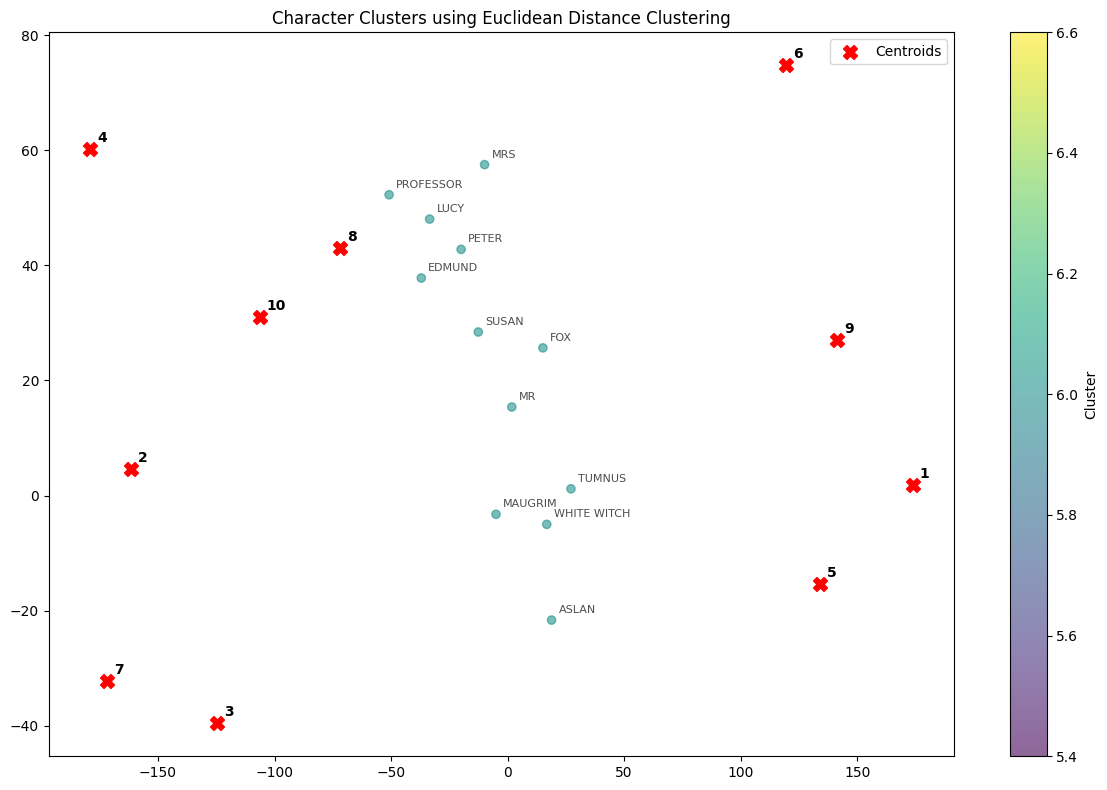


Cluster Statistics:

Cluster 6:
Size: 12
Sample characters: MRS, PETER, SUSAN, EDMUND, LUCY


In [148]:
plot_clusters(bert_embeddings[0], character_categories_digit, bert_embeddings[1], method="Euclidean Distance Clustering", centroids=centroid_list, centroid_labels=centroid_label)